*Exercise: To better understand what typical charging sessions look like, carry out a cluster
analysis to provide management with a succinct report of archetypical charging events. Think of an
appropriate trade-off between explainability and information content and try to come up with names
for these clusters. What is the value of identifying different types of charging sessions?*

General Idea: For the clustering of the user groups is to use k-means clustering. The k-means clustering algorithm is used to find user groups which have not been labeled in the data. We use this clustering to better understand our user groups and their behaviour.


In [48]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from pytz import timezone
import seaborn as sns

In [49]:
# load CSV-File
file_path = "../data/processed/charging_sessions_cleaned.csv"
df = pd.read_csv(file_path, parse_dates=["connectionTime", "disconnectTime"])
df.head()

,Unnamed: 0,id,connectionTime,disconnectTime,doneChargingTime,kWhDelivered,sessionID,siteID,stationID,timezone,userID,userInputs,duration,durationUntilFullCharge,chargingPower
0,0,5e23b149f9af8b5fe4b973cf,2020-01-02 13:08:54+00:00,2020-01-02 19:11:15+00:00,2020-01-02 17:31:35+00:00,25.016,1_1_179_810_2020-01-02 13:08:53.870034,1,1-1-179-810,America/Los_Angeles,194.0,"[{'WhPerMile': 250, 'kWhRequested': 25.0, 'mil...",6.039167,4.378056,5.713952
1,1,5e23b149f9af8b5fe4b973d0,2020-01-02 13:36:50+00:00,2020-01-02 22:38:21+00:00,2020-01-02 20:18:05+00:00,33.097,1_1_193_825_2020-01-02 13:36:49.599853,1,1-1-193-825,America/Los_Angeles,4275.0,"[{'WhPerMile': 280, 'kWhRequested': 70.0, 'mil...",9.025278,6.687500,4.949084
2,2,5e23b149f9af8b5fe4b973d1,2020-01-02 13:56:35+00:00,2020-01-03 00:39:22+00:00,2020-01-02 16:35:06+00:00,6.521,1_1_193_829_2020-01-02 13:56:35.214993,1,1-1-193-829,America/Los_Angeles,344.0,"[{'WhPerMile': 400, 'kWhRequested': 8.0, 'mile...",10.713056,2.641944,2.468258
3,3,5e23b149f9af8b5fe4b973d2,2020-01-02 13:59:58+00:00,2020-01-02 16:38:39+00:00,2020-01-02 15:18:45+00:00,2.355,1_1_193_820_2020-01-02 13:59:58.309319,1,1-1-193-820,America/Los_Angeles,1117.0,"[{'WhPerMile': 400, 'kWhRequested': 8.0, 'mile...",2.644722,1.313056,1.793527
4,4,5e23b149f9af8b5fe4b973d3,2020-01-02 14:00:01+00:00,2020-01-02 22:08:40+00:00,2020-01-02 18:17:30+00:00,13.375,1_1_193_819_2020-01-02 14:00:00.779967,1,1-1-193-819,America/Los_Angeles,334.0,"[{'WhPerMile': 400, 'kWhRequested': 16.0, 'mil...",8.144167,4.291389,3.116707


In [50]:
# Convert timezone to local timezone (America/Los_Angeles) or first set to utc and then convert to local timezone
local_timezone = timezone("America/Los_Angeles") #TODO Zeitzone erfolgreich aus dataframe auslesen "timezone(df['timezone'].to_string())" - alle Daten in der gleichen Zeitzone, daher kann es erstmal vernachlässigt werden

if df['connectionTime'].dt.tz is None:
    df['connectionTime'] = df['connectionTime'].dt.tz_localize('UTC').dt.tz_convert(local_timezone)
else:
    df['connectionTime'] = df['connectionTime'].dt.tz_convert(local_timezone)

if df['disconnectTime'].dt.tz is None:
    df['disconnectTime'] = df['disconnectTime'].dt.tz_localize('UTC').dt.tz_convert(local_timezone)
else:
    df['disconnectTime'] = df['disconnectTime'].dt.tz_convert(local_timezone)

# Feature-Engineering
df['hourOfDay'] = df['connectionTime'].dt.hour
features = df[['duration', 'hourOfDay', 'siteID']].dropna()
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64824 entries, 0 to 64823
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   duration   64824 non-null  float64
 1   hourOfDay  64824 non-null  int32  
 2   siteID     64824 non-null  int64  
dtypes: float64(1), int32(1), int64(1)
memory usage: 1.2 MB


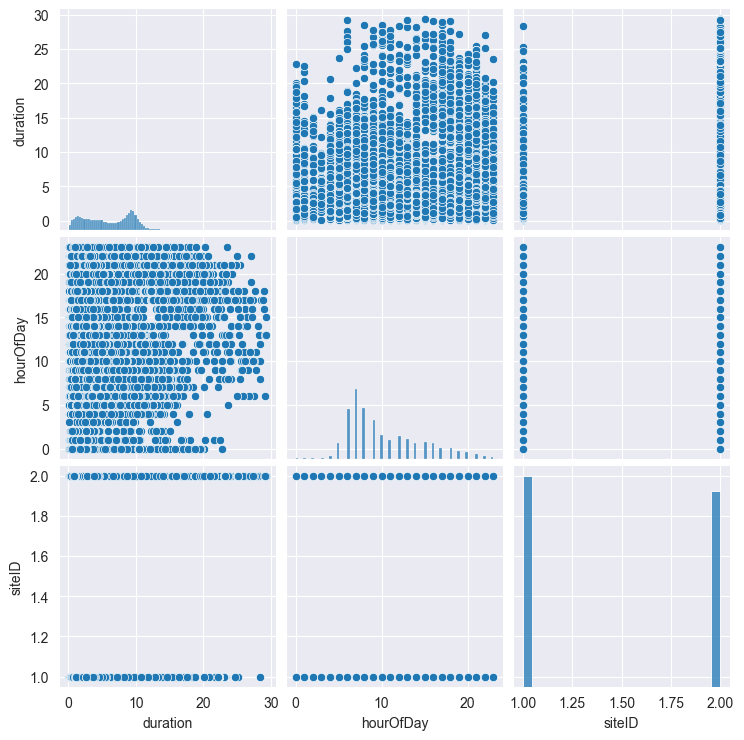

In [51]:
# create Pairplot
sns.pairplot(data=features)

In this Pairplot we can already see that site 1, the private hub does not experience charging sessions as long as site 2. This might be due to users charging their vehicles over the weekend or overnight more often at the public site 2.<br>
We can also see that there is a correlation between *duration* and the *hour of day*.

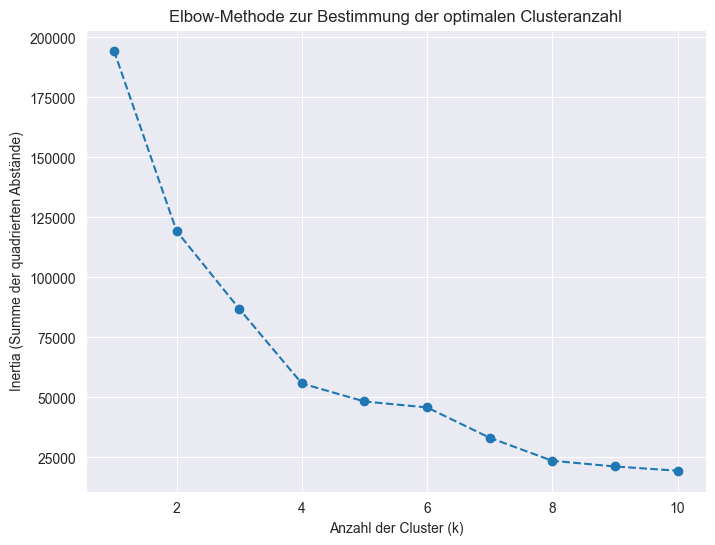

In [52]:
# normalize Data
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Elbow-Method to determine the optimal number of clusters
inertia = []
cluster_range = range(1, 11)

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    inertia.append(kmeans.inertia_)

# Elbow-Plot erstellen
plt.figure(figsize=(8, 6))
plt.plot(cluster_range, inertia, marker='o', linestyle='--')
plt.title("Elbow-Method for the optimal number of clusters")
plt.xlabel("Number of clusters")
plt.ylabel("Inertia (SSE)")
plt.grid(True)
plt.show()

In [53]:
# determine best silhouette score
best_score = -1
best_k = 0
for k in range(2, 11):
    print(f"Calculating silhouette score for {k} clusters...")
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(scaled_features)
    score = silhouette_score(scaled_features, cluster_labels)
    print(f"Silhouette score for {k} clusters: {score:.2f}")
    if score > best_score:
        best_score = score
        best_k = k

print(f"Best silhouette score: {best_score:.2f} with {best_k} clusters.")

Calculating silhouette score for 2 clusters...
Silhouette score for 2 clusters: 0.42
Calculating silhouette score for 3 clusters...
Silhouette score for 3 clusters: 0.42
Calculating silhouette score for 4 clusters...
Silhouette score for 4 clusters: 0.50
Calculating silhouette score for 5 clusters...
Silhouette score for 5 clusters: 0.47
Calculating silhouette score for 6 clusters...
Silhouette score for 6 clusters: 0.47
Calculating silhouette score for 7 clusters...
Silhouette score for 7 clusters: 0.48
Calculating silhouette score for 8 clusters...
Silhouette score for 8 clusters: 0.50
Calculating silhouette score for 9 clusters...
Silhouette score for 9 clusters: 0.50
Calculating silhouette score for 10 clusters...
Silhouette score for 10 clusters: 0.46
Best silhouette score: 0.50 with 8 clusters


In [54]:
# Clusteranalysis with the optimal number of clusters
optimal_k = best_k
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
features['cluster'] = kmeans.fit_predict(scaled_features)

# reverse scaling
cluster_centers = scaler.inverse_transform(kmeans.cluster_centers_)

# Print clusters
print(f"\nCluster centers ({optimal_k} Cluster):")
for i, center in enumerate(cluster_centers):
    print(f"Cluster {i + 1}:")
    print(f"  Charging duration: {center[0]:.2f} hours")
    print(f"  Starting time (in hours): {center[1]:.2f}")
    print(f"  Location-ID: {center[2]:.2f}")
    print()


Cluster-Zentren (8 Cluster):
Cluster 1:
  Ladezeit = 8.70 Stunden
  Stunde des Tages = 8.58
  Standort-ID = 2.00

Cluster 2:
  Ladezeit = 9.57 Stunden
  Stunde des Tages = 6.60
  Standort-ID = 1.00

Cluster 3:
  Ladezeit = 3.19 Stunden
  Stunde des Tages = 14.34
  Standort-ID = 1.00

Cluster 4:
  Ladezeit = 3.20 Stunden
  Stunde des Tages = 12.95
  Standort-ID = 2.00

Cluster 5:
  Ladezeit = 14.35 Stunden
  Stunde des Tages = 18.63
  Standort-ID = 1.98

Cluster 6:
  Ladezeit = 2.75 Stunden
  Stunde des Tages = 8.12
  Standort-ID = 2.00

Cluster 7:
  Ladezeit = 4.60 Stunden
  Stunde des Tages = 7.79
  Standort-ID = 1.00

Cluster 8:
  Ladezeit = 1.73 Stunden
  Stunde des Tages = 18.10
  Standort-ID = 2.00



KeyboardInterrupt: 

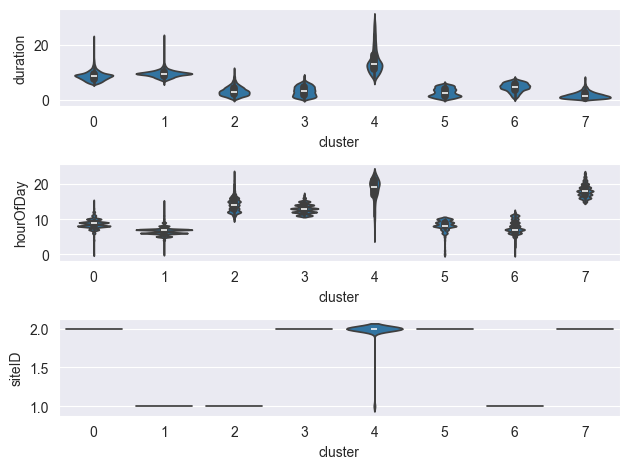

In [58]:
# visualize data in violin plots
fig, axs = plt.subplots(3, 1)
for i, col in enumerate(features.columns):
    if col != "cluster":
        sns.violinplot(
            x=features['cluster'],
            y=features[col],
            ax=axs[i],
            data=features,
        )
plt.tight_layout()
plt.savefig(f"../output/cluster_analysis.png", format="png", dpi=300)

In [56]:
# print cluster sizes
cluster_size = features.groupby('cluster').size()
cluster_size

cluster
0    11601
1    17326
2     8230
3     6445
4     1422
5     5611
6     8018
7     6171
dtype: int64

### **Results:**
 We can see that the users can be clustered into 8 different groups. The clusters are based on the charging duration, the starting time of the charge, and the location ID.
The private hub (Location ID 1) only serves employees, leading to predictable charging patterns aligned with work schedules. Charging sessions are generally longer, starting early in the day for a full day session or until lunch break or starting right after lunch until workers get off work, and cater to the needs of commuters who rely on the hub for consistent energy replenishment. In contrast, the public site (Location ID 2) exhibits more diverse usage patterns. Shorter, spontaneous charging sessions are more common, often reflecting the varied schedules of students and visitors. Public charging also sees activity later in the day, indicating a broader range of user types and needs.


### **The Clusters**
*Cluster 1:* Public Full Day Chargers<br>
  Average charging duration: 8.70 hours<br>
  Starting time of charge: 8.58<br>
  Location-ID: 2.00<br>

*Cluster 2:* Private Full Day Chargers<br>
  Average charging duration: 9.57 hours<br>
  Starting time of charge: 6.60<br>
  Location-ID: 1.00<br>

*Cluster 3:* Private Afternoon Chargers<br>
  Average charging duration: 3.19 hours<br>
  Starting time of charge: 14.34<br>
  Location-ID: 1.00<br>

*Cluster 4:* Public Lunchtime Chargers<br>
  Average charging duration: 3.20 hours<br>
  Starting time of charge: 12.95<br>
  Location-ID: 2.00<br>

*Cluster 5:* Overnight Chargers<br>
  Average charging duration: 14.35 hours<br>
  Starting time of charge: 18.63<br>
  Location-ID: 1.98<br>

*Cluster 6:* Public Morning Chargers<br>
  Average charging duration: 2.75 hours<br>
  Starting time of charge: 8.12<br>
  Location-ID: 2.00<br>

*Cluster 7:* Private Morning Chargers<br>
  Average charging duration: 4.60 hours<br>
  Starting time of charge: 7.79<br>
  Location-ID: 1.00<br>

*Cluster 8:* Public Evening Chargers<br>
  Average charging duration: 1.73 hours<br>
  Starting time of charge: 18.10<br>
  Location-ID: 2.00<br>